Initial Test For Temporal Patterns from SNNs
=========================

The justification here is that we just want to see if an SNN based network is capable of learning temporal patterns enough to differentiate between a synthesised flute and a real one. The intuition is that the key distinctions between a synthesised flute and a real one are going to be the temporal patterns as opposed to the frequencies. So we just do an initial experiment without digging too deeply to see whether or not these types of patterns are found.

In [21]:
!pip install torch==1.11 snntorch pandas spikingjelly numpy seaborn librosa tqdm torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

import math
import time
import os
import sys
import numpy as np
import librosa as lr
import librosa.effects as lreff
from tqdm.notebook import tqdm, trange
import seaborn as sns
from IPython.display import Markdown, Audio
import matplotlib.pyplot as plt

import pandas as pd

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Start by examining some real audio

Just to get a feel for the Mel Spectrum of the data, we start by loading a real audio sample and plotting the frequency domain, the mel frequency, and the MFCC.

In [2]:
import librosa as lr

audio, sr = lr.load('data/parents.wav')
display(Audio(audio, rate=sr))
audio.shape

(56203,)

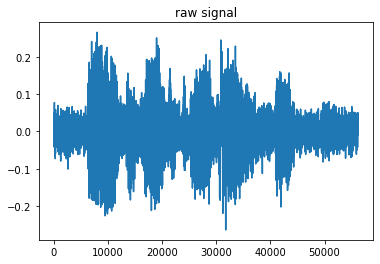

22050

In [3]:
%matplotlib inline

plt.figure(1)
plt.title("raw signal")
plt.plot(audio)
plt.show()
sr

In [4]:
# do the stft
audiotensor = torch.from_numpy(audio).unsqueeze(0)
stft = torch.stft(audiotensor, n_fft=8192, return_complex=True)
stft_abs = np.abs(stft)

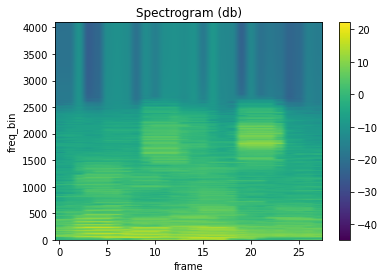

torch.Size([1, 4097, 28])

In [5]:
# from torchaudio example: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(lr.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

plot_spectrogram(stft_abs[0])
stft_abs.shape

/home/karagon/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1102) may be set too high. Or, the value for `n_freqs` (2206) may be set too low.
  warnings.warn(


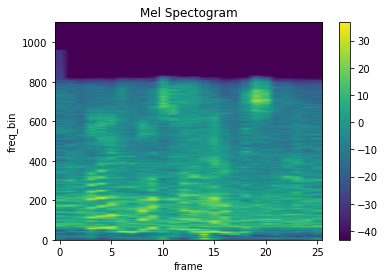

torch.Size([1, 1102, 26])

In [6]:
import torchaudio

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=4410, n_mels=1102, f_min=20, f_max=17000)
melspectrum = mel_spectrogram(torch.from_numpy(audio).unsqueeze(0))
plot_spectrogram(melspectrum[0], title='Mel Spectogram')
melspectrum.shape

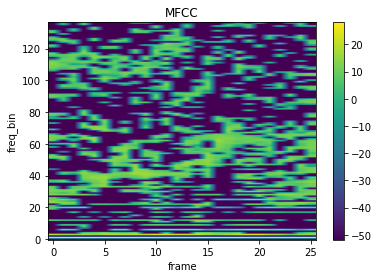

torch.Size([1, 137, 26])

In [7]:
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=137, melkwargs={'n_fft': 4410, 'n_mels': 1102, 'f_min': 20, 'f_max': 17000})
mfcc = mfcc_transform(torch.from_numpy(audio).unsqueeze(0))
plot_spectrogram(mfcc[0], title='MFCC')
mfcc.shape

# Define a layer that we can use to extract these two features

We use the log of the Mel frequency as the core frequency to mimic human logarithmic hearing in terms of both frequency and power. Then we extract a reduced set of Mel Cepstrum Coefficients to capture the timbre of the sample. These serve as our inputs at each time step.

In [8]:
class MelFreqAndMFCCLayer(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        sr = 44100
        if 'rate' in kwargs:
            sr = kwargs['rate']
        
        n_fft = int(sr/10)
        n_mels = int(n_fft/4)
        self.input_size = n_fft
        self._mspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, 
            n_fft=n_fft,
            n_mels=n_mels,
            f_min=20, 
            f_max=17000)
        
        n_mfcc = int(n_mels/4)
        self._mfcc = transform = torchaudio.transforms.MFCC(
            sample_rate=sr, 
            n_mfcc=n_mfcc,
            log_mels=True,
            melkwargs={
                'n_fft': n_fft, 
                'n_mels': n_mels, 
                'f_min': 20, 
                'f_max': 17000
            })
        
        self.output_size = n_mels + n_mfcc

    def forward(self, x):

        # get the melspectrum
        mspec = self._mspec(x)
        mfcc = self._mfcc(x)
        mfcc -= torch.min(mfcc)
        
        return torch.cat((mspec, mfcc), dim=len(x.shape) - 1)
    
testlayer = MelFreqAndMFCCLayer(rate=sr)
features = testlayer(torch.from_numpy(audio).unsqueeze(0))
features

/home/karagon/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (551) may be set too high. Or, the value for `n_freqs` (1103) may be set too low.
  warnings.warn(


tensor([[[6.5550e-04, 2.2489e-04, 3.7381e-04,  ..., 3.0860e-03,
          7.5290e-03, 2.8189e-03],
         [2.1413e-01, 5.5695e-03, 1.6644e-02,  ..., 3.2506e-01,
          2.2460e-02, 6.4397e+00],
         [1.3143e-01, 3.4185e-03, 1.0216e-02,  ..., 1.9952e-01,
          1.3786e-02, 3.9527e+00],
         ...,
         [1.1913e+02, 1.2182e+02, 1.2017e+02,  ..., 1.2367e+02,
          1.2193e+02, 1.2325e+02],
         [1.1915e+02, 1.1976e+02, 1.2155e+02,  ..., 1.2151e+02,
          1.2011e+02, 1.1969e+02],
         [1.2230e+02, 1.1984e+02, 1.2185e+02,  ..., 1.1939e+02,
          1.1981e+02, 1.1984e+02]]])

# Define the model

The above gives us a pytorch layer that can take a raw audio signal and convert it to a sequence of stft windows. This uses that to create the rest of the model with the binary classification output which is on a per-stft window basis. The caller can use the mode to pick the singular label. 

In [10]:
import snntorch as snn
from snntorch import surrogate
import snntorch.utils as utils

def default_spike_grad(x):
    return surrogate.FastSigmoid.apply(x, 100)

class ClassificationModel(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self._input = MelFreqAndMFCCLayer(**kwargs)
        self._lifin = snn.Synaptic(
            beta=torch.full((self._input.output_size,), 0.999, dtype=torch.float),
            alpha=torch.full((self._input.output_size,), 1.0, dtype=torch.float),
            reset_mechanism='zero',
            spike_grad=default_spike_grad,
            learn_alpha=True,
            learn_beta=True,
            learn_threshold=False,
            init_hidden=True)
        self._dconn = nn.Linear(self._input.output_size, 32)
        self._lifreduced = snn.Leaky(
            beta=torch.full((32,), 0.999, dtype=torch.float),
            learn_beta=True,
            learn_threshold=False,
            spike_grad=default_spike_grad,
            init_hidden=True)
        self._labelconn = nn.Linear(32, 1)
        self._out = snn.Leaky(
            beta=0.99,
            learn_beta=False,
            learn_threshold=False,
            spike_grad=default_spike_grad, 
            init_hidden=True, 
            output=True)
        
    def forward(self, x):        
        spk_rec = []
        mem_rec = []
        
        utils.reset(self)
        
        i = 0
        while i < x.shape[-1]:
            cur0 = x[..., i:i+self._input.input_size]
            cur0 = nn.functional.pad(cur0, pad=(0, self._input.input_size - cur0.shape[-1]), mode='constant', value=0)
            
            cur1 = self._input(cur0)
            spk1 = self._lifin(cur1[..., 1])
            cur2 = self._dconn(spk1)
            
            spk2 = self._lifreduced(cur2)
            cur3 = self._labelconn(spk2)
            
            spk3, mem3 = self._out(cur3)
            spk_rec.append(spk3)
            mem_rec.append(mem3)
            
            i += self._input.input_size
            
        return torch.hstack(spk_rec), torch.hstack(mem_rec)

# try a simple forward pass
model = ClassificationModel(rate=sr)
model.forward(torch.stack((torch.from_numpy(audio), torch.from_numpy(audio))))


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]], grad_fn=<CatBackward0>),
 tensor([[-0.1655, -0.3294, -0.6188, -0.7781, -0.9908, -1.2893, -1.4419, -1.6624,
          -1.8113, -1.9587, -1.9772, -2.1229, -2.3767, -2.5184, -2.8045, -2.9420,
          -3.0781, -3.3400, -3.4721, -3.6029, -3.7324, -3.8606, -3.9875, -4.1132,
          -4.2375, -4.3607],
         [-0.1655, -0.3294, -0.6188, -0.7781, -0.9908, -1.2893, -1.4419, -1.6624,
          -1.8113, -1.9587, -1.9772, -2.1229, -2.3767, -2.5184, -2.8045, -2.9420,
          -3.0781, -3.3400, -3.4721, -3.6029, -3.7324, -3.8606, -3.9875, -4.1132,
          -4.2375, -4.3607]], grad_fn=<CatBackward0>))

# Do an actual training run with the flute audio

We'll do full passes of multiple files. But we'll just focus on classifying the synthetic flute vs the acoustic one.


## Dataset

We set up a dataset that will iterate through synth files on-demand. Trying to load thousands of audio files, fully decompressed, into memory could be prohibitively large. So we want to pass these through as a dataset loading into memory only what is needed. 

## Loss Function

We use a custom loss function that broadly uses an MSE with some extras. Namely, we allow a certain number of the predictions to be wrong since we're looking for temporal patterns. We also have bias in the dataset so we tune the loss to try to de-bias the model.

In [12]:
import glob
import snntorch.functional as SF
import snntorch.backprop as BP

class GlobWavDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self._files = glob.glob(files)
        
    def __len__(self):
        return len(self._files)
    
    def __getitem__(self, idx):
        filename = self._files[idx]
        label = 1 if '_acoustic_' in filename else 0
        result, _ = lr.load(filename, sr=22050, mono=True)
        return torch.from_numpy(result), label, filename


def evaluate_model(model, fileglob, limit=None, quiet=True, preprocess=None):
    model.eval()
    
    batch_size = min(limit, 50) if limit is not None else 50
    
    test_ds = GlobWavDataset(fileglob)
    test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=batch_size)
    
    with torch.no_grad():
        cmat = np.zeros((2, 2), dtype=np.int32)
        for i, (data, targets, filenames) in enumerate(iter(test_dl)):
            if preprocess is not None:
                data = preprocess(data)
            data = data.to(device)
            predictions, _ = model(data)
            
            plabel, _ = torch.mode(predictions, 1)
            plabel = plabel.int()

            for batchindex in range(targets.shape[0]):
                cmat[targets[batchindex], plabel[batchindex]] += 1
            
                if not quiet:
                    print('{}: predicted {}, actual {} - {}'.format(
                        (i * batch_size) + batchindex, 
                        plabel[batchindex],
                        targets[batchindex], 
                        '✅' if targets[batchindex] == plabel[batchindex] else '❌ ({})'.format(filenames[batchindex])))

            
            if limit is not None and (i * batch_size) >= limit:
                break
            
        return cmat


class SpikingMSELoss(nn.Module):
    # contrary to initial design, ramp up the penalties to allow the model to converge
    # onto the positive labels and unlearn the false positives
    def __init__(self, correct_threshold=0.8, bias_beta=1+1e-6, bias_penalty=1e-3):
        super().__init__()
        self._threshold = correct_threshold
        self._zero_bias = bias_penalty
        self._beta = bias_beta
        
    def forward(self, pred, actual):
        # get the mean of the predictions made
        pred_mean = torch.mean(pred, dim=1)
        
        # determine the expected value
        expected_mean = actual
        
        # get the mse for the sum
        mse = (pred_mean - expected_mean) ** 2
        
        # figure out how much leniency to allow
        leniency = (1.0 - self._threshold) ** 2
        
        # get the per-element loss
        loss = torch.relu(mse - leniency)
        
        # we are modeling the real world here. When actual is 0 and we 
        # predict 1, we want to add an extra penalty because the data
        # will be heavily biased toward 0. There are more sounds that
        # are not real flutes than are flutes. So we want the model
        # to err on the side of calling it a not-flute. Meaning we want
        # to penalize it harder when it says flute but it's not one.
        adjusted_loss = loss + (loss * (1 - actual) * self._zero_bias)
        self._zero_bias *= self._beta

        # arbitrary limit added later because beyond this performance
        # just degrades
        if self._zero_bias > 2:
            self._zero_bias = 2
        
        # normalise and get the mean
        return torch.mean(adjusted_loss)

#device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = ClassificationModel(rate=sr).to(device)

optimizer = optim.NAdam(model.parameters(), lr=0.00005, betas=(0.9, 0.999))
#optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.9)
loss_fn = SpikingMSELoss(correct_threshold=0.55, bias_beta=1.001, bias_penalty=0.1)

best_accuracy = 0


# Run the training loop

We found that 2-3 epochs is actually usually the sweet spot with this whole data set, so we run for 5 epochs for good measure.


In [880]:
train_dataset = GlobWavDataset('data/nsynth-train/audio/flute*.wav')

num_epochs = 5
loss_hist = []
validation_acc = 0

# training loop
for epoch in range(num_epochs):
    cmat = torch.zeros((2, 2), dtype=torch.int32)
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=20)
   
    print(f"Epoch {epoch}")
    for i, (batch, targets, _) in enumerate(pbar := tqdm(iter(train_loader))):
        model.train()

        spk_rec, mem = model(batch)
        loss_val = loss_fn(spk_rec, targets.float())

        # capture the confusion matrix
        plabel, _ = torch.mode(spk_rec, 1)
        plabel = plabel.int()

        for batchindex in range(targets.shape[0]):
            cmat[targets[batchindex], plabel[batchindex]] += 1
   
        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        trainacc = (cmat[0, 0] + cmat[1, 1]) / torch.sum(cmat)
        pbar.set_description(f"loss {np.mean(loss_hist):.2f}/{np.std(loss_hist):.2f}, acc {trainacc * 100:.2f} validation acc {validation_acc * 100:.2f}")
        
        # validate every 10 iterations
        if i and i % 25 == 0:
            vmat = evaluate_model(model, 'data/nsynth-valid/audio/flute*.wav', 50)
            validation_acc = (vmat[0, 0] + vmat[1, 1]) / np.sum(vmat)
               
            pbar.set_description(f"loss {np.mean(loss_hist):.2f}/{np.std(loss_hist):.2f}, acc {trainacc * 100:.2f} validation acc {validation_acc * 100:.2f}")
        
            loss_hist = []
            cmat = torch.zeros((2, 2), dtype=torch.int32)

    trainacc = (cmat[0, 0] + cmat[1, 1]) / torch.sum(cmat)
    vmat = evaluate_model(model, 'data/nsynth-valid/audio/flute*.wav')
    vacc = (vmat[0, 0] + vmat[1, 1]) / np.sum(vmat)
    
    print(f"Epoch {epoch} Train Loss: {np.mean(loss_hist):.2f}, Train Accuracy: {trainacc * 100:.2f}, Validation Accuracy: {vacc * 100:.2f}%")
    
    if vacc > best_accuracy:
        torch.save(model.state_dict(), 'mfccmodel.pth')
        best_accuracy = vacc
    else:
        print('- Model Score not improved')

Epoch 0


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 0 Train Loss: 0.03, Train Accuracy: 76.28, Validation Accuracy: 94.68%
- Model Score not improved
Epoch 1


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.03, Train Accuracy: 77.08, Validation Accuracy: 94.68%
- Model Score not improved
Epoch 2


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.03, Train Accuracy: 69.96, Validation Accuracy: 94.68%
- Model Score not improved
Epoch 3


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.04, Train Accuracy: 77.87, Validation Accuracy: 94.68%
- Model Score not improved
Epoch 4


  0%|          | 0/439 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Model testing and Validation

There are two layers to validation. First we want to see how well the model runs against the test set. But we also want to validate that it's learning temporal patterns. To do this, we'll compare the performance of the model over the entire sound file against the performance of the model over small "blips" of data.


0: predicted 1, actual 0 - ❌ (data/nsynth-test/audio/flute_synthetic_000-057-100.wav)
1: predicted 0, actual 0 - ✅
2: predicted 0, actual 0 - ✅
3: predicted 1, actual 1 - ✅
4: predicted 0, actual 0 - ✅
5: predicted 1, actual 0 - ❌ (data/nsynth-test/audio/flute_synthetic_000-057-050.wav)
6: predicted 0, actual 0 - ✅
7: predicted 0, actual 0 - ✅
8: predicted 0, actual 0 - ✅
9: predicted 1, actual 1 - ✅
10: predicted 1, actual 1 - ✅
11: predicted 0, actual 0 - ✅
12: predicted 1, actual 1 - ✅
13: predicted 1, actual 1 - ✅
14: predicted 0, actual 0 - ✅
15: predicted 0, actual 0 - ✅
16: predicted 0, actual 0 - ✅
17: predicted 0, actual 0 - ✅
18: predicted 1, actual 1 - ✅
19: predicted 0, actual 0 - ✅
20: predicted 0, actual 0 - ✅
21: predicted 1, actual 1 - ✅
22: predicted 0, actual 0 - ✅
23: predicted 0, actual 0 - ✅
24: predicted 0, actual 0 - ✅
25: predicted 0, actual 0 - ✅
26: predicted 0, actual 0 - ✅
27: predicted 0, actual 0 - ✅
28: predicted 1, actual 0 - ❌ (data/nsynth-test/audio/fl

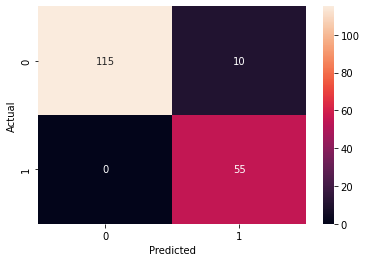

accuracy:  31.71%
precision: 31.71%
recall:    100.00%


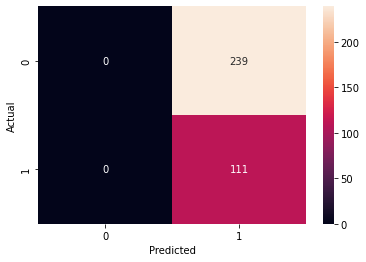

In [14]:
# let's test it on some specific files
best_model = ClassificationModel(rate=sr)
best_model.load_state_dict(torch.load('mfccmodel.pth'))
best_model = best_model.to(device)

cmat = evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', quiet=False)
hm = sns.heatmap(cmat, annot=True, fmt='d')
hm.set(xlabel='Predicted', ylabel='Actual')
print('accuracy:  {:.2f}%'.format(100 * ((cmat[0, 0] + cmat[1, 1]) / np.sum(cmat))))
print('precision: {:.2f}%'.format(cmat[1, 1] * 100 / np.sum(cmat, axis=0)[1]))
print('recall:    {:.2f}%'.format(cmat[1, 1] * 100 / np.sum(cmat, axis=1)[1]))
plt.show()

# compare to a window sample which should theoretically perform much worse
def sample_window(data):
    # pick a random offset aligned to our sample window
    index = np.random.randint(int(data.shape[-1] / 2205) - 3)
    index *= 2205
    return data[..., index:index+6615]

# take 5 random samples to compare against
cmat = evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', limit=35, quiet=True, preprocess=sample_window)
cmat += evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', limit=35, quiet=True, preprocess=sample_window)
cmat += evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', limit=35, quiet=True, preprocess=sample_window)
cmat += evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', limit=35, quiet=True, preprocess=sample_window)
cmat += evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', limit=35, quiet=True, preprocess=sample_window)

hm = sns.heatmap(cmat, annot=True, fmt='d')
hm.set(xlabel='Predicted', ylabel='Actual')
print('accuracy:  {:.2f}%'.format(100 * ((cmat[0, 0] + cmat[1, 1]) / np.sum(cmat))))
print('precision: {:.2f}%'.format(cmat[1, 1] * 100 / np.sum(cmat, axis=0)[1]))
print('recall:    {:.2f}%'.format(cmat[1, 1] * 100 / np.sum(cmat, axis=1)[1]))


# Revisiting with noise data availabile

Months later, I come back to this model and try it with noise introduced


In [20]:
# we need an index of the class labels
class_labels = pd.read_csv('data/audioset/class_labels_indices.csv', index_col=0)
class_labels = class_labels.set_index('mid').to_dict()['display_name']

audioset = pd.read_csv('data/audioset/balanced_train_segments.csv')
def named_labels(labels):
    return set(class_labels[s.strip()] for s in labels.split(','))
    
audioset['length'] = audioset['end_seconds'] - audioset['start_seconds']
audioset['labels'] = audioset['positive_labels'].apply(named_labels)
audioset.drop(labels=['positive_labels'], axis=1, inplace=True)

def is_noise(labels):
    return 'Hubbub, speech noise, speech babble' in labels or 'White noise' in labels or 'Vibration' in labels

audioset = audioset[audioset['labels'].apply(is_noise)]
len(audioset)

os.makedirs('tools', exist_ok=True)

if not os.path.exists('tools/youtube-dl'):
    !curl -L https://yt-dl.org/downloads/latest/youtube-dl -o tools/youtube-dl

os.makedirs('data/audioset/audio', exist_ok=True)
filenames = []
for i, row in audioset.iterrows():
    audio_filename = f'data/audioset/audio/{row["YTID"]}.wav'
    
    filenames.append(audio_filename)
        
    
audioset = audioset.copy()
audioset['filename'] = filenames

audioset = audioset[audioset['filename'].apply(os.path.exists)]
audioset

,YTID,start_seconds,end_seconds,length,labels,filename
121,-ETSfElMyNc,220.0,230.0,10.0,{White noise},data/audioset/audio/-ETSfElMyNc.wav
293,-dEOa2GkXHw,30.0,40.0,10.0,"{Speech, White noise}",data/audioset/audio/-dEOa2GkXHw.wav
611,0MJPqGKIbZg,20.0,30.0,10.0,"{Hubbub, speech noise, speech babble, Speech, ...",data/audioset/audio/0MJPqGKIbZg.wav
617,0NSzeHaja5o,30.0,40.0,10.0,"{Hubbub, speech noise, speech babble, Speech, ...",data/audioset/audio/0NSzeHaja5o.wav
779,0fm0oU8FO0U,30.0,40.0,10.0,"{Vehicle, White noise, Helicopter}",data/audioset/audio/0fm0oU8FO0U.wav
...,...,...,...,...,...,...
21007,w61ekNETEgc,320.0,330.0,10.0,"{Boat, Water vehicle, Vehicle, Motorboat, spee...",data/audioset/audio/w61ekNETEgc.wav
21413,xXjmPTooKvs,30.0,40.0,10.0,"{Engine starting, Motor vehicle (road), Vehicl...",data/audioset/audio/xXjmPTooKvs.wav
21664,yMdOxfnxkB0,10.0,20.0,10.0,"{Hubbub, speech noise, speech babble, Music, S...",data/audioset/audio/yMdOxfnxkB0.wav
21915,zIM4eLqtczE,0.0,10.0,10.0,"{Hubbub, speech noise, speech babble, Speech}",data/audioset/audio/zIM4eLqtczE.wav


0: predicted 0, actual 0 - ✅
1: predicted 0, actual 0 - ✅
2: predicted 0, actual 1 - ❌ (data/nsynth-test/audio/flute_acoustic_002-098-075.wav)
3: predicted 0, actual 0 - ✅
4: predicted 0, actual 0 - ✅
5: predicted 0, actual 1 - ❌ (data/nsynth-test/audio/flute_acoustic_002-091-075.wav)
6: predicted 1, actual 0 - ❌ (data/nsynth-test/audio/flute_synthetic_000-100-025.wav)
7: predicted 0, actual 1 - ❌ (data/nsynth-test/audio/flute_acoustic_002-098-127.wav)
8: predicted 0, actual 0 - ✅
9: predicted 0, actual 0 - ✅
10: predicted 1, actual 1 - ✅
11: predicted 0, actual 1 - ❌ (data/nsynth-test/audio/flute_acoustic_002-101-127.wav)
12: predicted 0, actual 0 - ✅
13: predicted 0, actual 0 - ✅
14: predicted 0, actual 0 - ✅
15: predicted 0, actual 0 - ✅
16: predicted 0, actual 0 - ✅
17: predicted 0, actual 1 - ❌ (data/nsynth-test/audio/flute_acoustic_002-067-025.wav)
18: predicted 0, actual 0 - ✅
19: predicted 0, actual 0 - ✅
20: predicted 0, actual 0 - ✅
21: predicted 0, actual 1 - ❌ (data/nsynth-

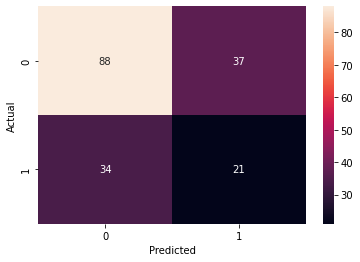

In [24]:


# change the meaning of GlobWavDataset
class GlobWavDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self._files = glob.glob(files)
        
    def __len__(self):
        return len(self._files)
    
    def __getitem__(self, idx):
        filename = self._files[idx]
        label = 1 if '_acoustic_' in filename else 0
        result, _ = lr.load(filename, sr=22050, mono=True)
        
        result = torch.from_numpy(result)
        amplitude = (torch.rand(1)[0] * 0.9) + 0.1
        result *= amplitude
        
        if torch.randint(0, 10, size=(1,))[0] > 2:
            noise_amplitude = torch.rand(1)[0] * amplitude
            noise = audioset['filename'].iloc[torch.randint(0, audioset.shape[0], size=(1,))[0].item()]
            noise, _ = lr.load(noise, sr=22050, mono=True)
            
            rate = noise.shape[0] / result.shape[0] 
            noise = lreff.time_stretch(noise, rate = rate)
            noise = torch.from_numpy(noise)
            result += noise * noise_amplitude
            
        return result, label, filename

cmat = evaluate_model(best_model, 'data/nsynth-test/audio/flute*.wav', quiet=False)
hm = sns.heatmap(cmat, annot=True, fmt='d')
hm.set(xlabel='Predicted', ylabel='Actual')
print('accuracy:  {:.2f}%'.format(100 * ((cmat[0, 0] + cmat[1, 1]) / np.sum(cmat))))
print('precision: {:.2f}%'.format(cmat[1, 1] * 100 / np.sum(cmat, axis=0)[1]))
print('recall:    {:.2f}%'.format(cmat[1, 1] * 100 / np.sum(cmat, axis=1)[1]))
plt.show()

# Manually Inspect Model Weights

It's not clear how this model learned, but it did. Getting this right is beyond the scope of this iteration of the model but understanding how it's working may help moving forward.

In [16]:
for name, para in best_model.named_parameters():
    print(f'{name}: {para}')

_lifin.beta: Parameter containing:
tensor([0.9866, 0.9904, 0.9831, 1.0002, 1.0001, 0.9990, 1.0001, 0.9891, 1.0001,
        1.0002, 1.0002, 1.0001, 1.0000, 1.0000, 0.9990, 1.0001, 0.9962, 1.0002,
        1.0004, 1.0003, 0.9973, 1.0000, 1.0001, 1.0000, 1.0002, 0.9940, 1.0001,
        1.0000, 0.9993, 1.0002, 1.0000, 1.0001, 1.0002, 1.0001, 1.0000, 0.9964,
        1.0001, 1.0001, 0.9925, 0.9971, 1.0000, 0.9964, 1.0002, 0.9996, 1.0001,
        1.0000, 0.9975, 1.0000, 0.9955, 1.0002, 0.9970, 1.0001, 0.9943, 0.9977,
        0.9941, 0.9981, 1.0003, 1.0010, 1.0001, 1.0007, 1.0000, 1.0002, 1.0000,
        1.0004, 1.0002, 1.0001, 1.0005, 1.0000, 0.9976, 0.9958, 0.9974, 0.9940,
        1.0001, 1.0001, 1.0002, 1.0001, 0.9980, 1.0001, 1.0001, 0.9978, 1.0001,
        1.0002, 0.9963, 0.9994, 1.0001, 0.9973, 0.9980, 1.0001, 1.0001, 1.0001,
        1.0003, 1.0003, 1.0002, 1.0002, 1.0001, 0.9936, 1.0001, 1.0000, 1.0001,
        1.0001, 1.0001, 1.0001, 1.0000, 1.0001, 0.9977, 1.0000, 0.9981, 1.0002,
     